# CP Distance Analysis

## Setup

Formatting

<style>
body, .jp-Notebook {
    font-family: 'Source Sans 3', serif !important;
}


table {
    font-family: 'Source Sans 3', sans-serif;
}

table td, table th {
    text-align: center !important;
}

/* Optional: keep first column left-aligned if it contains labels */
table td:first-child, table th:first-child {
    text-align: left !important;
}
</style>

### Imports

In [1]:
thoo = 4
thoo

4

In [2]:
from warnings import simplefilter

import pandas as pd

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=DeprecationWarning)
simplefilter(action="ignore", category=FutureWarning)

import re
import textwrap
from pathlib import Path
from pyprocessmacro import Process
from statsmodels.stats.multitest import multipletests

import os
import numpy as np
import pyperclip
import statsmodels.api as sm
from matplotlib import colormaps
from scipy import stats
from IPython.display import Markdown, display
from io import StringIO
import matplotlib.pyplot as plt
from collections import defaultdict
import subprocess
from tqdm.notebook import tqdm

from reload_recursive import reload_recursive
import sys

sys.path.insert(0, "/home/srs-9/Projects/ms_mri/analysis/thalamus/helpers")

import helpers
import utils
import regression_utils as regutils
import my_namespace

In [3]:
reload_recursive(regutils)
reload_recursive(helpers)
reload_recursive(utils)
reload_recursive(my_namespace)

import utils
from utils import load_df, zscore, get_colors
from my_namespace import *

import regression_utils as regutils
from regression_utils import (
    quick_regression,
    quick_regression2,
    residualize_vars,
    run_regressions,
)

### Load Data

#### Clinical and Volumes

In [4]:
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/figures_tables/5-CP_distance_gradient"
)
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

data_orig = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data.csv", index_col="subid"
)
data_origT = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data_transformed.csv",
    index_col="subid",
)

MS_patients = data_orig["dz_type2"] == "MS"
NONMS_patients = data_orig["dz_type2"] == "!MS"
NIND_patients = data_orig["dz_type5"] == "NIND"
OIND_patients = data_orig["dz_type5"] == "OIND"
RMS_patients = data_orig["dz_type5"] == "RMS"
PMS_patients = data_orig["dz_type5"] == "PMS"

thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
deep_grey = [13, 14, 26, 27, 28, 29, 30, 31, 32]
thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)["struct"]
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)["index"]

data_ms = data_orig[MS_patients]
data_ms_z = zscore(data_ms)

resid_data_z = data_ms_z.copy()
resid_data = data_ms.copy()
for var in all_predictors:
    resid_data[var] = utils.residualize_structs(data_ms, var, ["age", "Female", "tiv"])
    resid_data_z[var] = utils.residualize_structs(
        data_ms_z, var, ["age", "Female", "tiv"]
    )


grouped_nuclei = ["medial", "posterior", "ventral", "anterior"]

nuclei_rename_index = {k: f"**{k}**" for k in grouped_nuclei}

### Load Distances

In [5]:
data_dir = Path("/home/srs-9/Projects/ms_mri/data")

mean_thomas_vols = data_orig[hips_thomas_ref].rename(columns=hips_thomas_invref).mean()

# CP distances
choroid_dists_left = pd.read_csv(
    data_dir / "centroid-choroid_centroid-left.csv", index_col="subid"
)
choroid_dists_right = pd.read_csv(
    data_dir / "centroid-choroid_centroid-right.csv", index_col="subid"
)
choroid_dists = (choroid_dists_left + choroid_dists_right) / 2
new_cols = {str(i): f"{k}_CP_dist" for i, k in hips_thomas_ref.items()}
try:
    data_orig = data_orig.join([choroid_dists.rename(columns=new_cols)])
except ValueError:
    pass

mean_choroid_dists = choroid_dists.mean()
mean_choroid_dists.index = mean_choroid_dists.index.map(int)


# Ventricle SDT distances
ventricle_dists_sdt_left = pd.read_csv(
    data_dir / "centroid-ventricle_SDT-left.csv", index_col="subid"
)
ventricle_dists_sdt_right = pd.read_csv(
    data_dir / "centroid-ventricle_SDT-right.csv", index_col="subid"
)
ventricle_sdt_dists = (ventricle_dists_sdt_right + ventricle_dists_sdt_left) / 2
new_cols = {str(i): f"{k}_LV_sdt" for i, k in hips_thomas_ref.items()}
try:
    data_orig = data_orig.join([ventricle_sdt_dists.rename(columns=new_cols)])
except ValueError:
    pass

mean_ventricle_sdt_dists = ventricle_sdt_dists.mean()
mean_ventricle_sdt_dists.index = mean_ventricle_sdt_dists.index.map(int)


# Load other MNI dists
mni_outerCSF_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_outer_CSF_SDT.csv", index_col="index"
)
mni_outerCSF_dists["dist"] = (
    mni_outerCSF_dists["left_exposure"] + mni_outerCSF_dists["right_exposure"]
) / 2
mni_outerCSF_dists = mni_outerCSF_dists["dist"]

test_dist = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_ventricle_shortestSDT_tmp.csv", index_col="index"
)['left_exposure']
mni_allCSF_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_outer_CSF_SDT.csv", index_col="index"
)
mni_allCSF_dists["dist"] = (
    mni_allCSF_dists["left_exposure"] + mni_allCSF_dists["right_exposure"]
) / 2
mni_allCSF_dists = mni_allCSF_dists["dist"]

mni_allCSF_dists_norm = mni_allCSF_dists / (mean_thomas_vols**(1/3))

mni_ventricle_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_outer_CSF_SDT.csv", index_col="index"
)
mni_ventricle_dists["dist"] = (
    mni_ventricle_dists["left_exposure"] + mni_ventricle_dists["right_exposure"]
) / 2
mni_ventricle_dists = mni_ventricle_dists["dist"]

mni_viewfactors = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_viewfactor_test1.csv", index_col="index")['dose']

In [6]:
mni_viewfactors

index
2      22.664687
4      26.203083
5       8.795836
6      85.546463
7      53.198906
8     211.576760
9      11.232957
10      8.388346
11     16.232031
12     55.126431
13      2.811953
14      2.857642
26      9.361719
27    100.990129
28     35.685789
29     14.674044
30      9.879145
31     77.335192
32     13.397773
Name: dose, dtype: float64

### Functions

In [8]:
def plot_xordered_data(
    data,
    x_name,
    y_name,
    label_name,
    loc=(0.8, 0.05),
    fit_line=False,
    fdr=False,
    xlabel=None,
    ylabel=None,
    title=None,
    axes=None,
    fig=None,
    legend=False,
    fit_params=True,
    hide_x=False,
    fontsize=10,
    legend_fontsize=10,
    bbox_to_anchor=None,
    text_x = None,
    text_y = None,
    sig_only = False
):
    if fdr:
        p_col = "p_fdr"
    else:
        p_col = "pval"

    if xlabel is None:
        xlabel = x_name
    if ylabel is None:
        ylabel = y_name
    if title is None:
        title = f"{ylabel} vs {xlabel}"

    if axes is None:
        fig, axes = plt.subplots(1)
    data.sort_values(by=x_name, inplace=True)
    if sig_only:
        data = data[data[p_col] < 0.05]
    for i, row in data.iterrows():
        c = row[x_name] / data[x_name].max()
        if p_col in data.columns and data.loc[i, p_col] >= 0.05:
            marker = "x"
        else:
            marker = "D"
        if legend:
            label = data.loc[i, label_name]
        else:
            label = None
        axes.scatter(
            data.loc[i, x_name],
            data.loc[i, y_name],
            marker=marker,
            color=viridis(c),
            label=label,
        )

    xlims = axes.get_xlim()
    ylims = axes.get_ylim()

    slope, intercept, r_value, p_value, std_err = stats.linregress(
        data[x_name], data[y_name]
    )
    if fit_line:
        x = np.array([xlims[0], xlims[1]])
        y = slope * x + intercept
        axes.plot(x, y, c="black")

    if fit_params:
        text = "R2={:0.2f}\np={:0.2f}".format(r_value**2, p_value)
        if text_y is None:
            text_y = ylims[0] + (ylims[1] - ylims[0]) * 0.9
        if text_x is None:
            text_x = xlims[0] + (xlims[1] - xlims[0]) * 0.05
        axes.text(text_x, text_y, text)

    axes.set_xbound([xlims[0], xlims[1] * 1.1])
    if legend:
        axes.legend(loc=loc, bbox_to_anchor=bbox_to_anchor, fontsize=legend_fontsize)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_title(title)
    if hide_x:
        axes.xaxis.set_major_formatter(plt.NullFormatter())
        axes.set_xlabel("")

    return fig, axes, data


def bootstrap_procedure(
    model_data,
    all_distances,
    covariates,
    predictor,
    structs,
    n_boots=1000,
    inverse_slope=False,
) -> tuple:
    df_to_sample = model_data.join(all_distances)
    df_to_sample = df_to_sample.reset_index()
    struct_i = hips_thomas_invref[structs]
    struct_str = [str(i) for i in struct_i]

    t_stats = np.zeros((n_boots,))
    slopes = np.zeros((n_boots,))
    intercepts = np.zeros((n_boots,))
    r_values = np.zeros((n_boots,))
    for i_samp in tqdm(range(n_boots), total=n_boots):
        inds = np.random.randint(0, df_to_sample.index.max(), len(df_to_sample))
        sample_data = df_to_sample.loc[inds, :]
        distances = sample_data[struct_str].mean()
        new_index = [int(ind) for ind in distances.index]
        distances.index = new_index
        _, results, formulas = regutils.run_regressions(
            sample_data,
            structs,
            [predictor],
            covariates,
        )
        data = results[predictor].set_index(hips_thomas_invref[structs])

        data["dist"] = distances
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            data["dist"], data["coef"]
        )
        t_stats[i_samp] = slope / std_err
        slopes[i_samp] = slope
        r_values[i_samp] = r_value
        intercepts[i_samp] = intercept

    if inverse_slope:
        p_boot = sum(t_stats >= 0) / n_boots
    else:
        p_boot = sum(t_stats <= 0) / n_boots
    # print("Bootstrapped p: {:0.2f}".format(p_boot))
    return slopes, intercepts, r_values, p_boot

## Analysis

### Influence of CP Decreases with Distance

To better understand the relationship between CP volume and localized atrophy, we regressed all thalamic nuclei and deep grey volumes on CP volume, with peripheral CSF fraction as an additional covariate to isolate central effects. We plotted the standardized coefficients for deep grey and thalamic volumes with respect to CP volume against each structure’s distance from the CP

#### Remove points that weren't significant

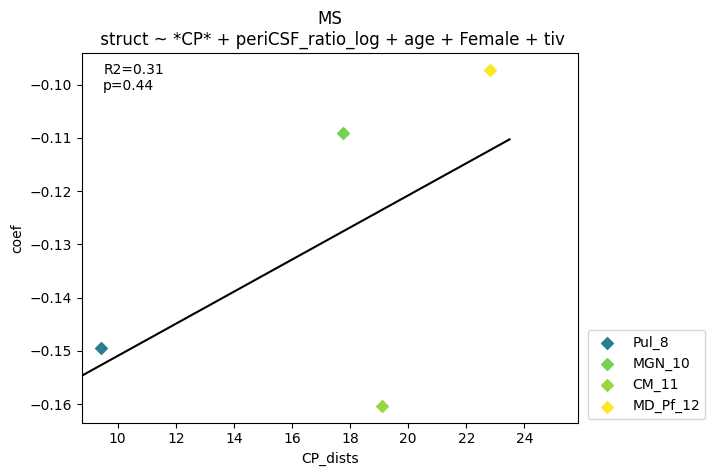

#### Keep all points

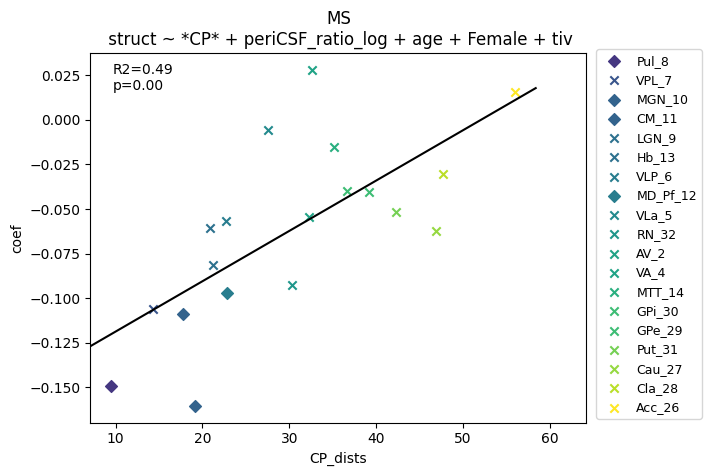

In [21]:
save = False
show = True
save_stem = "CP_betas_vs_CP_dists"

model_data = data_ms_z
model_data['periCSF_frac_test'] = np.log(model_data['periCSF_frac'].max() + 1 - model_data['periCSF_frac'])

covariates = ["periCSF_ratio_log", "age", "Female", "tiv"]
covariates_str = " + ".join(covariates)
structs = hips_thomas_ref[thalamic_nuclei + deep_grey]

predictor = ["CP", "LV_log"]

_, results, formulas = regutils.run_regressions(
    model_data,
    structs,
    predictor,
    covariates,
    robust_cov=None
)

var_to_plot = "CP"
data = results[var_to_plot]
data.set_index(hips_thomas_invref[structs], inplace=True)
data.insert(1, "struct", hips_thomas_ref)

data["CP_dists"] = mean_choroid_dists
data["allCSF_dists"] = mni_allCSF_dists
data["allCSF_dists_norm"] = mni_allCSF_dists_norm
data["outerCSF_dists"] = mni_outerCSF_dists
data["ventricle_SDT_dist"] = mean_ventricle_sdt_dists
data["ventricle_centroid_dist"] = mean_ventricle_sdt_dists

data["test_dist"] = test_dist
data['viewfactors'] = mni_viewfactors**(1/3)

dist_measure = "CP_dists"

display(Markdown("#### Remove points that weren't significant"))
fig, axes = plt.subplots()
axs = axes
_, _, plot_data = plot_xordered_data(
    data,
    dist_measure,
    "coef",
    "struct",
    fit_line=True,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    sig_only=True,
    legend_fontsize=10
)
plt.show()
sig_structs = plot_data.index

fig, axes = plt.subplots()
axs = axes
plot_xordered_data(
    data,
    dist_measure,
    "coef",
    "struct",
    fit_line=True,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    sig_only=False,
    legend_fontsize=9
)
display(Markdown("#### Keep all points"))


if save:
    save_path = fig_path / f"{save_stem}.png"
    # # Extract the legend
    legend = axs.get_legend()
    legend.remove()  # Remove it from the main plot

    fig_legend = plt.figure(figsize=(2, 4))  # Adjust size as needed
    fig_legend.legend(handles=legend.legend_handles, labels=[t.get_text() for t in legend.get_texts()], 
                    loc='center', frameon=False)
    fig_legend.savefig(fig_path / f"{save_stem}_legend.png", bbox_inches='tight', dpi=300)

    # Save the main plot without legend
    fig.savefig(fig_path / f"{save_stem}.png", bbox_inches='tight', dpi=300)


#### Remove points that weren't significant

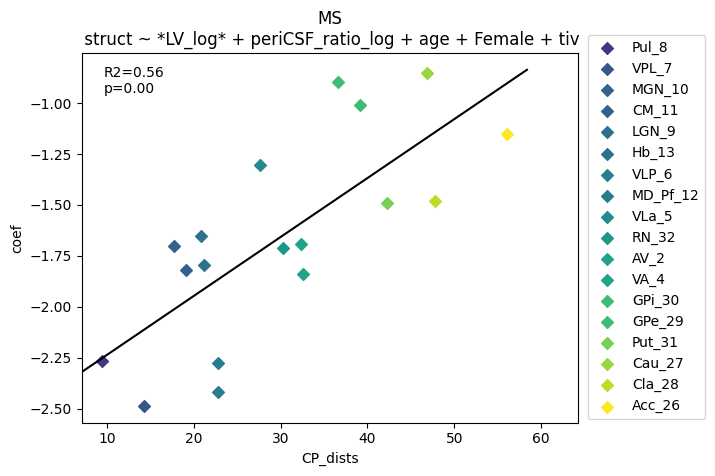

#### Keep all points

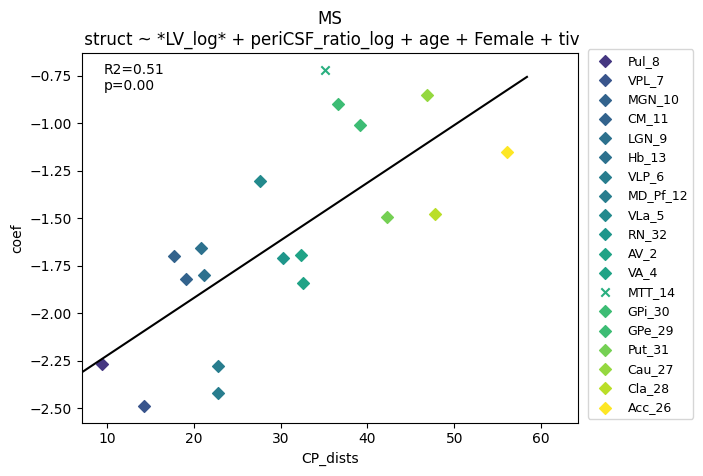

In [67]:
save = False
show = True
save_stem = "CP_betas_vs_CP_dists"

model_data = data_ms_z
model_data['periCSF_frac_test'] = np.log(model_data['periCSF_frac'].max() + 1 - model_data['periCSF_frac'])

covariates = ["periCSF_ratio_log", "age", "Female", "tiv"]
covariates_str = " + ".join(covariates)
structs = hips_thomas_ref[thalamic_nuclei + deep_grey]

predictor = ["CP", "LV_log"]

_, results, formulas = regutils.run_regressions(
    model_data,
    structs,
    predictor,
    covariates,
    robust_cov=None
)

var_to_plot = "LV_log"
data = results[var_to_plot]
data.set_index(hips_thomas_invref[structs], inplace=True)
data.insert(1, "struct", hips_thomas_ref)

data["CP_dists"] = mean_choroid_dists
data["allCSF_dists"] = mni_allCSF_dists
data["outerCSF_dists"] = mni_outerCSF_dists
data["ventricle_SDT_dist"] = mean_ventricle_sdt_dists
data["ventricle_centroid_dist"] = mean_ventricle_sdt_dists


display(Markdown("#### Remove points that weren't significant"))
fig, axes = plt.subplots()
axs = axes
_, _, plot_data = plot_xordered_data(
    data,
    "CP_dists",
    "coef",
    "struct",
    fit_line=True,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    sig_only=True,
    legend_fontsize=10
)
plt.show()
sig_structs = plot_data.index

fig, axes = plt.subplots()
axs = axes
plot_xordered_data(
    data,
    "CP_dists",
    "coef",
    "struct",
    fit_line=True,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    sig_only=False,
    legend_fontsize=9
)
display(Markdown("#### Keep all points"))


if save:
    save_path = fig_path / f"{save_stem}.png"
    # # Extract the legend
    legend = axs.get_legend()
    legend.remove()  # Remove it from the main plot

    fig_legend = plt.figure(figsize=(2, 4))  # Adjust size as needed
    fig_legend.legend(handles=legend.legend_handles, labels=[t.get_text() for t in legend.get_texts()], 
                    loc='center', frameon=False)
    fig_legend.savefig(fig_path / f"{save_stem}_legend.png", bbox_inches='tight', dpi=300)

    # Save the main plot without legend
    fig.savefig(fig_path / f"{save_stem}.png", bbox_inches='tight', dpi=300)


(array([  6.,  40.,  99., 103.,  84.,  66.,  34.,  20.,  10.,   5.]),
 array([0.        , 0.19993145, 0.39986291, 0.59979436, 0.79972581,
        0.99965727, 1.19958872, 1.39952017, 1.59945163, 1.79938308,
        1.99931454]),
 <BarContainer object of 10 artists>)

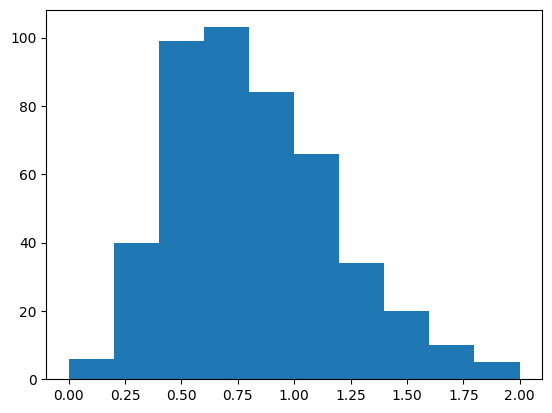

In [36]:
plt.hist(np.log(model_data['periCSF_frac'].max() + 1 - model_data['periCSF_frac']))

In [ ]:
slopes, intercepts, r_values, p_boot = bootstrap_procedure(
    model_data, choroid_dists, covariates, var_to_plot, hips_thomas_ref[sig_structs]
)

Text(9.664058283977107, -0.05, 'Bootstrapped:\nR2=0.46\np=0.00')

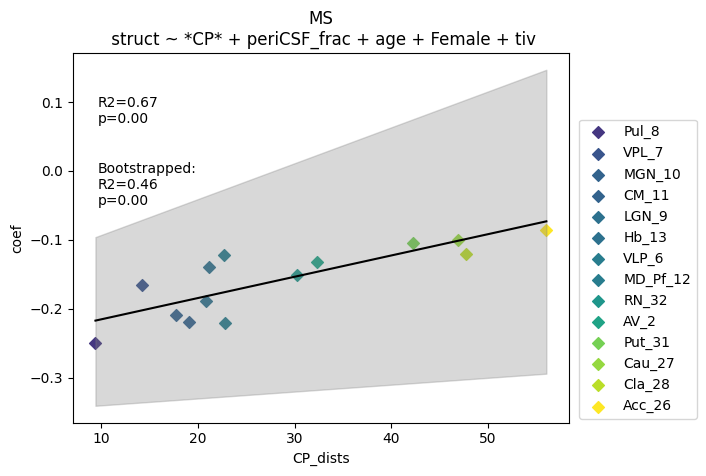

In [15]:
x_range = np.linspace(data['CP_dists'].min(), data['CP_dists'].max())
sort_slopes = sorted(slopes)
sort_intercepts = sorted(intercepts)
y_low = sort_intercepts[25] + sort_slopes[25]*x_range
y_high = sort_intercepts[975] + sort_slopes[975]*x_range
y = intercepts.mean() + slopes.mean()*x_range

r2 = r_values.mean()**2
p = p_boot

fig, axs = plt.subplots()

plot_xordered_data(
    plot_data,
    "CP_dists",
    "coef",
    "struct",
    fit_line=False,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    text_y = 0.07
)

axs.fill_between(x_range, y_low, y_high, alpha=0.3, color="gray")
axs.plot(x_range, y, color='black')
xlims = axs.get_xlim()
ylims = axs.get_ylim()
text = "Bootstrapped:\nR2={:0.2f}\np={:0.2f}".format(r2, p)
# text_y = ylims[0] + (ylims[1] - ylims[0]) * 0.85
text_y = -0.05
text_x = xlims[0] + (xlims[1] - xlims[0]) * 0.05
axs.text(text_x, text_y, text, fontsize=10)
